# Gaussian Mixture Model (NIR beers dataset)

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.7


## Import local utility functions and classes

In [2]:
import sys
sys.path.append('../utils')
import utils as utl
from data import Data

## Model configuration

In [3]:
# model mode
model_mode      = 'training'
#model_mode      = 'sampling'

# data filenames
#data_filename   = '../../data/beers/NIR_beers.csv'
data_filename   = '../../code/test/dummy_data_e.csv'
trace_filename  = './traces/trace_beers_nir'

## Load dataset, import and plot samples

In [4]:
# init dataset object
data_obj = Data(data_filename, 'label', -1)   
data_obj.data.head(5)
data = data_obj.data
data.head(5)

,200.0,201.0,202.0,203.0,204.0,205.0,206.0,207.0,208.0,209.0,...,392.0,393.0,394.0,395.0,396.0,397.0,398.0,399.0,400.0,label
27,18.851841,18.771087,18.481267,18.817623,18.809060,18.751860,18.772262,18.702795,19.059584,19.153956,...,28.375602,28.393339,28.340391,28.418289,28.306917,28.271049,28.583918,28.526106,28.567332,A
15,7.862568,7.727617,7.694043,7.758479,7.926550,7.696324,7.640914,7.773900,7.791056,7.597320,...,8.760809,8.596633,8.574433,8.534737,8.534696,8.516861,8.458772,8.462198,8.542151,A
23,9.635100,9.473978,9.459937,9.618529,9.572544,9.594432,9.618982,9.812064,9.765868,9.574694,...,17.766461,17.693520,17.812515,17.922115,17.907770,17.641407,17.903532,17.943278,17.718722,B
17,11.576806,11.632242,11.836864,11.572980,11.621219,11.594883,11.897765,11.636969,11.782109,11.826825,...,14.460271,14.409483,14.504309,14.348954,14.481209,14.632189,14.501123,14.567821,14.490671,A
8,15.439271,15.428418,15.388596,15.380135,15.592033,15.778605,15.656163,15.905758,15.649872,15.854367,...,25.130495,25.080065,25.074152,25.106647,25.156709,25.223064,25.255771,25.211857,25.540916,A


A: blue
B: red


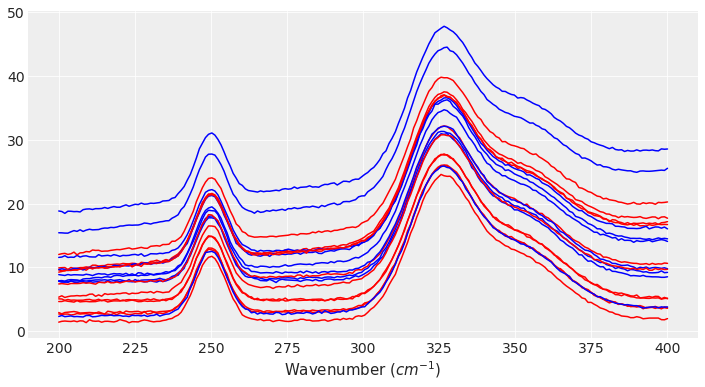

In [5]:
# list of class labels
class_labels = data_obj.get_class_labels()

# plot dataframe
utl.plot_data(data_obj, 20)

In [6]:
# number of samples from each class
print(data_obj.data[data_obj.label_column].value_counts())

A    15
B    15
Name: label, dtype: int64


In [7]:
# generate training and test sets
train_data, test_data = train_test_split(data_obj.data, train_size=0.8, random_state=42)

# rename the index
test_data.index = range(len(test_data))
train_data.index = range(len(train_data))

In [8]:
test_data.shape

(6, 201)

In [9]:
train_data.shape

(24, 201)

# Model definition
The following model is assumed:

\begin{equation}
\large A_{m} \sim \text{U} (0, max(Y)) \\
\large \mu_{m} \sim \mathcal{N}(\mu_{m}, 50) \\
\large \sigma_{m} \sim |\mathcal{N}(0, 100)| \\
\large \epsilon \sim |\mathcal{N}(0, 1)| \\
\large \theta = \sum\limits_{m=1}^M [A_m \cdot e^{-\frac{(x_n-\mu_m)^2}{2\cdot\sigma_m^2}}] + \alpha \cdot x_n + \beta \\
\large y \sim \mathcal{N}(\theta, \epsilon)
\end{equation}

In [10]:
# 1D array of X values
x_val = np.array(train_data.columns[:data_obj.non_data_columns], dtype='float32')

# 2D array containing Y values (observation data)
x_n = train_data.columns[:data_obj.non_data_columns]
x_s = train_data[x_n].values

In [12]:
peaks = [3]
traces = []
models = []

# prior on peak positions
#mu_p = [180, 425, 720]
#peaks = [len(mu_p)]

for npeaks in peaks:
    if model_mode == 'training':
        print("training on " + str(npeaks) + " peaks")
    
    with pm.Model() as model:
        amp = pm.Uniform('amp', 0, x_s[0].max(), shape=(1,npeaks))
        mu = pm.Normal('mu', mu=np.linspace(x_val.min(), x_val.max(), npeaks), sd=50, 
                       shape=(1,npeaks), transform=pm.distributions.transforms.ordered)
        sigma = pm.HalfNormal('sigma', sd=100, shape=(1,npeaks))
        
        alpha = pm.Normal('alpha', mu=0, sd=1)
        beta = pm.Normal('beta', mu=0, sd=1)
        
        epsilon = pm.HalfNormal('epsilon', sd=1)

        y = pm.Deterministic('y', (amp.T * np.exp(-(x_val - mu.T)**2/(2 * sigma.T**2))).sum(axis=0) +
                             alpha*x_val + beta)
        
        y_pred = pm.Normal('y_pred', mu=y, sd=epsilon, observed=x_s)
        
        if model_mode == 'training':
            #trace = pm.sample(2000, init='adapt_diag', random_seed=42)
            trace = pm.sample(2000, init='adapt_diag')
            traces.append(trace)
            models.append(model)
        else:
            # load traces from trained model
            trace = pm.backends.text.load(trace_filename)
            traces.append(trace)
            models.append(model)
            break

training on 3 peaks


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, beta, alpha, sigma, mu, amp]
Sampling 2 chains: 100%|██████████| 5000/5000 [01:51<00:00, 44.66draws/s]
The acceptance probability does not match the target. It is 0.9754562164443892, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9840333884732093, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


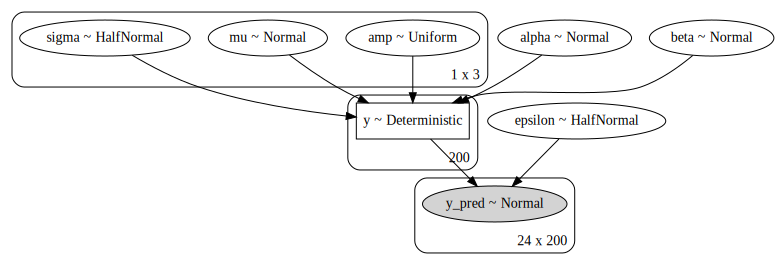

In [13]:
pm.model_to_graphviz(model)

# Model evaluation

In [14]:
#varnames = ['amp', 'mu', 'sigma', 'epsilon']
#coef = az.summary(traces[1], varnames)
#coef

In [15]:
#varnames = ['amp', 'mu', 'sigma', 'epsilon', 'alpha', 'beta']
#az.plot_trace(traces[0], varnames);

In [16]:
ppc_mm = [pm.sample_posterior_predictive(traces[i], samples=500, model=models[i]) for i in range(len(peaks))]

100%|██████████| 500/500 [00:01<00:00, 367.59it/s]


In [17]:
#data_ppc = az.from_pymc3(trace=traces[0], posterior_predictive=ppc_mm[0])
#ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)

## Compare distribution of data and posterior samples

In [18]:
#plt.figure(figsize=(12, 8))
#t = trace[:250]
#num = 5    
#for amp_, mu_, sigma_, alpha_, beta_, epsilon_ in zip(t['amp'][-num:], 
#                    t['mu'][-num:], t['sigma'][-num:], t['alpha'][-num:], t['beta'][-num:], t['epsilon'][-num:]):
#    plt.plot(x_val, (amp_.T * np.exp(-(x_val-mu_.T)**2/(2*sigma_.T**2)) + alpha_*x_val + beta_).sum(axis=0)\
#             , c='black', alpha=0.5, linewidth=1)

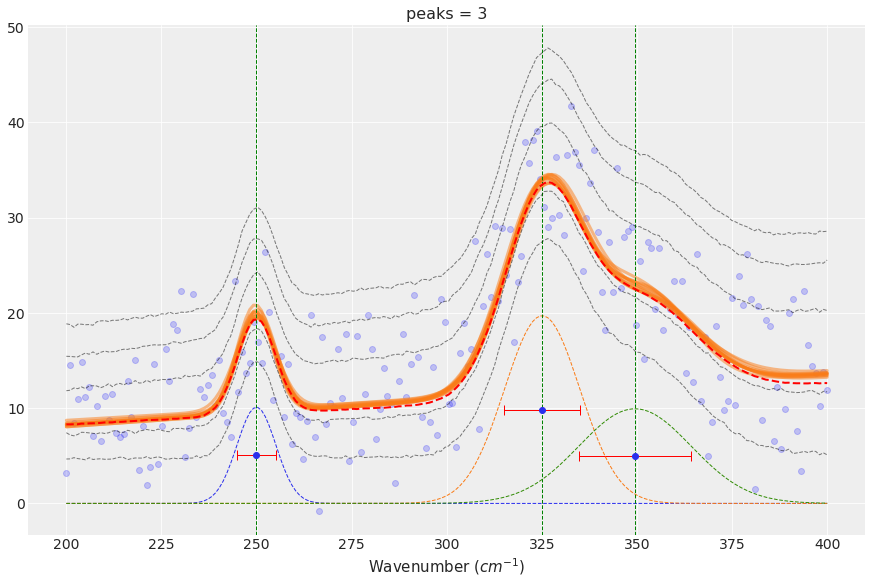

In [20]:
_, ax = plt.subplots(1, 1, figsize=(12, 8), constrained_layout=True)
ax = np.ravel(ax)
for idx, ppc_x in enumerate(ppc_mm):
    # plot samples from the posterior
    sp = ppc_x['y_pred']
    for i in range(1):
        ax[idx].plot(x_val, sp[i,0,:], 'o', color="blue", linewidth=1, alpha=.2)
    
    # plot samples from the posterior model formula
    for i in range(10):
        ax[idx].plot(x_val, traces[idx]['y'][i], color='C1', alpha=.5, linewidth=3)
    
    # plot mixture components 
    A = traces[idx]['amp'].mean(axis=0).flatten()
    M = traces[idx]['mu'].mean(axis=0).flatten()
    S = traces[idx]['sigma'].mean(axis=0).flatten()
    for j in range(len(A)):
        Y = A[j] * np.exp(-(x_val - M[j])**2/(2 * S[j]**2))
        ax[idx].plot(x_val, Y, '--', linewidth=1)
        ax[idx].axvline(M[j], linestyle='--', linewidth=1, color='g')
        ax[idx].errorbar(x=M[j], y=.5*A[j], xerr=S[j], fmt='o', 
                         ecolor='r', elinewidth=1, capsize=5, capthick=1)
        
    # plot samples from the dataset
    for i in range(5):
        y_val = train_data.values[i]
        ax[idx].plot(x_val, y_val[:data_obj.non_data_columns], '--', color="black", alpha=.5, linewidth=1)
        
    # plot the mean of the real data
    ax[idx].set(xlabel='Wavenumber ($cm^{-1}$)')
    ax[idx].plot(x_val, data_obj.data.iloc[:,:data_obj.non_data_columns].mean(), '--', color='red', linewidth=2);
    ax[idx].set_title('peaks = {}'.format(peaks[idx]))

In [21]:
if len(models)>1:
    comp = az.compare(dict(zip(peaks, traces)), method='BB-pseudo-BMA')
    print(comp)

In [22]:
if len(models)>1:
    az.plot_compare(comp);

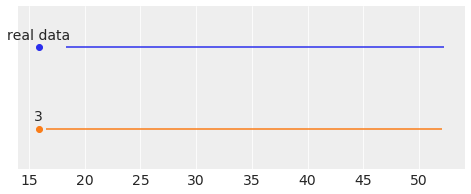

In [23]:
plt.figure(figsize=(8, 3))
data = [x_s]
dd = [ppc_mm[i]['y_pred'] for i in range(len(ppc_mm))]
data.extend(dd)
labels = ['real data']
pk = [str(peaks[i]) for i in range(len(peaks))]
labels.extend(pk)
for i, d in enumerate(data):
    mean = d.mean()
    err = np.percentile(d, [2.5, 97.5])
    plt.errorbar(mean, -i, xerr=[[-err[0]], [err[1]]], fmt='o')
    plt.text(mean, -i+0.1, labels[i], ha='center', fontsize=14)
plt.ylim([-i-0.5, 0.5])
plt.yticks([]);

In [24]:
if len(models)>1:
    for idx, trace in enumerate(traces):
        print(str(peaks[idx]) + " peaks, bfmi: " + str(az.bfmi(trace)))

In [25]:
for idx, ppc in enumerate(ppc_mm):
    print("--- " + str(peaks[idx]) + " peaks -----------\n" + str(az.r2_score(x_s, ppc['y_pred'])))

--- 3 peaks -----------
r2        0.621391
r2_std    0.014766
dtype: float64


In [26]:
varnames = ['amp', 'mu', 'sigma', 'epsilon', 'alpha', 'beta']
for idx, trace in enumerate(traces):
    print("\n--- " + str(peaks[idx]) + " peaks ----------------------------------")
    coef = az.summary(trace, varnames)
    print(coef)


--- 3 peaks ----------------------------------
               mean     sd   hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
amp[0,0]     10.104  0.481    9.185   10.979      0.009    0.006    2896.0   
amp[0,1]     19.701  1.712   16.277   22.306      0.057    0.040     902.0   
amp[0,2]      9.931  0.742    8.633   11.416      0.023    0.016    1060.0   
mu[0,0]     249.966  0.271  249.453  250.471      0.005    0.003    3169.0   
mu[0,1]     325.093  0.620  324.051  326.310      0.018    0.013    1196.0   
mu[0,2]     349.493  2.812  343.612  354.067      0.092    0.065     937.0   
sigma[0,0]    5.115  0.294    4.563    5.651      0.005    0.004    2948.0   
sigma[0,1]    9.951  0.496    8.975   10.864      0.015    0.010    1118.0   
sigma[0,2]   14.738  1.798   11.548   18.125      0.057    0.041     990.0   
epsilon       5.615  0.058    5.510    5.723      0.001    0.001    3090.0   
alpha         0.026  0.002    0.023    0.029      0.000    0.000    2008.0   
beta          3.


--- 3 peaks ----------------------------------


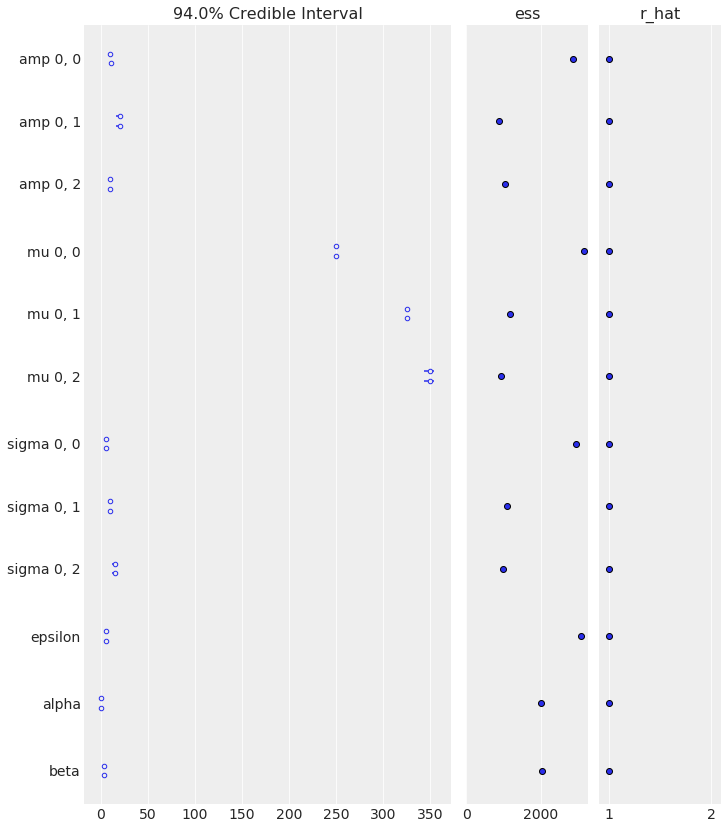

In [27]:
for idx, trace in enumerate(traces):
    print("\n--- " + str(peaks[idx]) + " peaks ----------------------------------")
    az.plot_forest(trace, var_names = ['amp', 'mu', 'sigma', 'epsilon', 'alpha', 'beta'], r_hat=True, ess=True);

## Save results

In [28]:
if model_mode == 'training':
    # save inference results
    pm.backends.text.dump(trace_filename, traces[0])